Al igual que los ojos y el cerebro humanos, OpenCV puede detectar las principales características de una imagen y extraerlas en los llamados descriptores de imagen. Estas características pueden utilizarse como base de datos para realizar búsquedas basadas en imágenes. Además, podemos utilizar puntos clave para unir imágenes y componer una imagen más grande. (Piense en juntar muchas imágenes para formar una panorámica de 360°).

Este capítulo le mostrará cómo detectar las características de una imagen con OpenCV y hacer uso de ellas para emparejar y buscar imágenes. A lo largo de este capítulo, tomaremos imágenes de muestra y detectaremos sus características principales, y luego trataremos de encontrar una región de otra imagen que coincida con la imagen de muestra. También encontraremos la homografía o relación espacial entre una imagen de muestra y una región coincidente de otra imagen.

Más concretamente, realizaremos las siguientes tareas:

---
* Detección de puntos clave y extracción de descriptores locales alrededor de los puntos clave utilizando cualquiera de los siguientes algoritmos: **Harris corners, SIFT, SURF u ORB**

* Coincidencia de puntos clave mediante **algoritmos de fuerza bruta** o el algoritmo **FLANN**.

* Filtrado de coincidencias erróneas mediante **KNN** y la prueba de proporción¨**ratio test**

* Búsqueda de la homografía entre dos conjuntos de puntos clave coincidentes

* Búsqueda en un conjunto de imágenes para determinar cuál de ellas contiene la mejor coincidencia con una imagen de referencia.
---

Terminaremos este capítulo construyendo una aplicación forense de prueba de concepto. Dada una imagen de referencia de un tatuaje, buscaremos un conjunto de imágenes de personas para encontrar a una persona con un tatuaje que coincida.


## Requisitos técnicos

Este capítulo utiliza Python, OpenCV y NumPy. En cuanto a OpenCV, utilizamos los módulos opcionales `opencv_contrib`, que incluyen algoritmos adicionales para la detección de puntos clave y el emparejamiento. Para habilitar el algoritmo **SURF** (que está patentado y no es libre para uso comercial), debemos configurar los módulos opencv_contrib con la bandera `OPENCV_ENABLE_NONFREE` en CMake. Por favor, consulte el Capítulo 1, Configuración de OpenCV, para obtener instrucciones de instalación. Además, si aún no ha instalado Matplotlib, instálelo ejecutando `pip install matplotlib` (o `pip3 install matplotlib`, dependiendo de su entorno).

El código completo de este capítulo puede encontrarse en el repositorio GitHub de este libro, https://github.com/PacktPublishing/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition, en la carpeta chapter06. Las imágenes de ejemplo se encuentran en la carpeta images.

Un subconjunto del código de ejemplo del capítulo puede editarse y ejecutarse interactivamente en Google Colab en https://colab.research.google.com/github/PacktPublishing/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/blob/main/chapter06/chapter06.ipynb.


# Tipos de detección y correspondencia de rasgos.

Se pueden utilizar varios algoritmos para detectar y describir características, y exploraremos varios de ellos en esta sección. Los algoritmos de detección de características y extracción de descriptores más utilizados en OpenCV son los siguientes:

---

**Harris:** Este algoritmo es útil para detectar esquinas.
**SIFT:** Este algoritmo es útil para detectar manchas.
**SURF:** Este algoritmo es útil para detectar manchas.
**FAST:** Este algoritmo es útil para detectar esquinas.
**BRIEF:** Este algoritmo sirve para detectar manchas.
**ORB:** este algoritmo es la abreviatura de FAST orientado y BRIEF girado. Sirve para detectar una combinación de esquinas y manchas.

---

El cotejo de características puede realizarse con los siguientes métodos:


---

**brute-force** Emparejamiento por fuerza bruta
**FLANN-based** Correspondencia basada en FLANN

---

La verificación espacial puede realizarse con homografía.
Acabamos de introducir mucha terminología y algoritmos nuevos. Ahora repasaremos sus definiciones básicas.

### Definición de las características

¿Qué es exactamente un rasgo? ¿Por qué una zona concreta de una imagen se puede clasificar como rasgo y otras no? En términos generales, una característica es un área de interés en la imagen que es única o fácilmente reconocible. Las esquinas y las regiones con una alta densidad de detalles texturales son buenos rasgos, mientras que los patrones que se repiten mucho y las regiones de baja densidad (como un cielo azul) no lo son. Los bordes son buenas características, ya que tienden a dividir dos regiones con cambios bruscos en los valores de intensidad (gris o color) de una imagen. Una mancha (una región de una imagen que difiere mucho de sus alrededores) también es una característica interesante.

La mayoría de los algoritmos de detección de rasgos giran en torno a la identificación de esquinas, bordes y manchas, y algunos también se centran en el concepto de cresta, que se puede conceptualizar como el eje de simetría de un objeto alargado. (Piense, por ejemplo, en la identificación de una carretera en una imagen).

Algunos algoritmos son mejores en la identificación y extracción de características de un determinado tipo, por lo que es importante saber cuál es su imagen de entrada para que pueda utilizar la mejor herramienta en su cinturón OpenCV.


## Detección de esquinas Harris
Empecemos por encontrar esquinas utilizando el algoritmo de detección de esquinas de Harris. Haremos esto implementando un ejemplo. Si continúa estudiando OpenCV más allá de este libro, encontrará que los tableros de ajedrez son un tema común de análisis en visión por computador, en parte porque un patrón a cuadros es adecuado para muchos tipos de detección de características, y en parte porque el ajedrez es un pasatiempo popular, especialmente en Rusia, que es el país de origen de muchos de los desarrolladores de OpenCV.

He aquí nuestra imagen de muestra de un tablero y piezas de ajedrez:
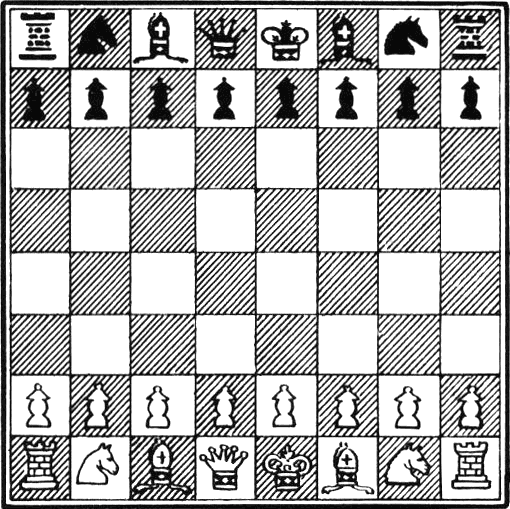
Figura 6.1: Un tablero de ajedrez, que se utilizará para la detección de esquinas

OpenCV tiene una función muy útil llamada `cv2.cornerHarris`, que detecta las esquinas en una imagen. Podemos ver esta función en el siguiente ejemplo básico:

```python
import cv2
img = cv2.imread('../images/chess_board.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 2, 23, 0.04)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2.imshow('corners', img)
cv2.waitKey()
```

Analicemos el código. Tras las importaciones habituales, cargamos la imagen del tablero de ajedrez y la convertimos a escala de grises. A continuación, llamamos a la función `cornerHarris`:

```python
dst = cv2.cornerHarris(gray, 2, 23, 0.04)
```

El parámetro más importante aquí es el tercero, que define la apertura o tamaño del núcleo del operador Sobel. El operador Sobel detecta los bordes midiendo las diferencias horizontales y verticales entre los valores de los píxeles en una vecindad, y lo hace utilizando un núcleo. La función cv2.cornerHarris utiliza un operador Sobel cuya apertura está definida por este parámetro. Los parámetros definen la sensibilidad de la detección de esquinas. Debe estar entre 3 y 31 y ser un valor impar. Con un valor bajo (muy sensible) de 3, todas esas líneas diagonales en los cuadrados negros del tablero de ajedrez se registrarán como esquinas cuando toquen el borde del cuadrado. Para un valor más alto (menos sensible) de 23, sólo las esquinas de cada cuadrado serán detectadas como esquinas.

cv2.cornerHarris devuelve una imagen en formato de coma flotante. Cada valor de esta imagen representa una puntuación para el píxel correspondiente en la imagen de origen. Una puntuación moderada o alta indica que es probable que el píxel sea una esquina. A la inversa, podemos tratar los píxeles con las puntuaciones más bajas como no-esquinas. Considere la línea siguiente:

```python
img[dst > 0.01 * dst.max()] = [0, 0, 255]
```

Aquí, seleccionamos los píxeles con puntuaciones que son al menos el 1% de la puntuación más alta, y coloreamos estos píxeles de rojo en la imagen original. He aquí el resultado:

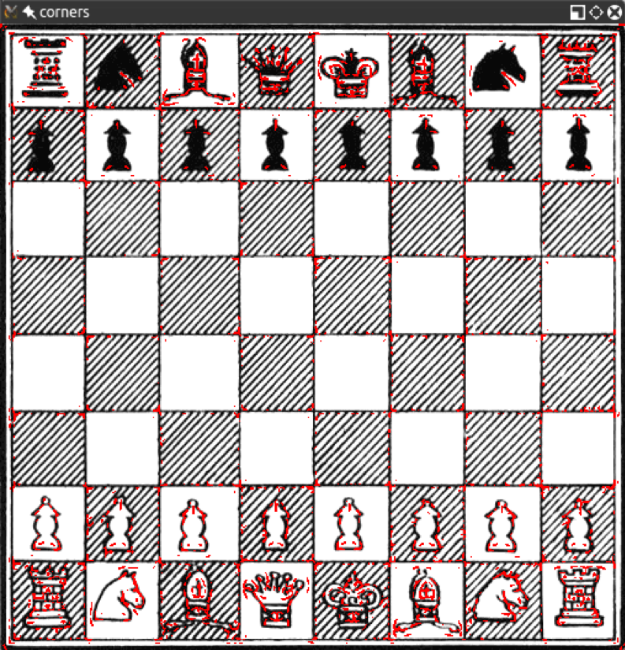 Figura 6.2: Detección de esquinas en un tablero de ajedrez

¡Genial! Casi todas las esquinas detectadas están marcadas en rojo. Los puntos marcados incluyen casi todas las esquinas de las casillas del tablero de ajedrez.

Si ajustamos el segundo parámetro en `cv2.cornerHarris`, veremos que regiones más pequeñas (para un valor de parámetro más pequeño) o regiones más grandes (para un valor de parámetro más grande) serán detectadas como esquinas. Este parámetro se llama tamaño de bloque.


#### Operador SOBEL
https://www.youtube.com/watch?v=6bXAhsXyKY8

1.1
(9, 7)


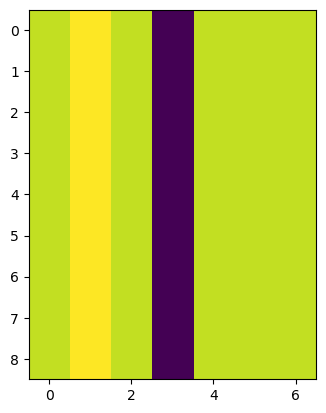

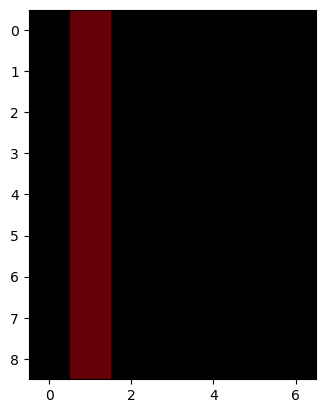

(523, 525, 3)


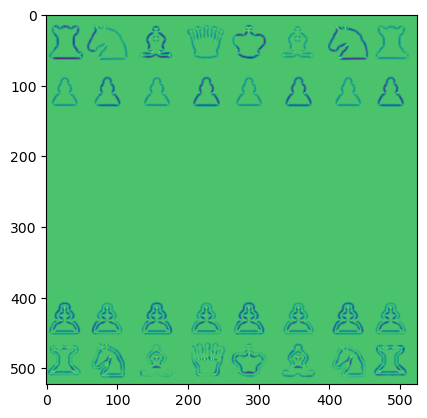

dst (523, 525)


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img


#Para probar los maximos y minimos
#Estoy porbando que ejercicio me da el array comporbar la funcion:
#imagen[dst > 0.001 * dst.max()] = [0, 0, 255] 
imgExample = np.zeros((9,7,3), dtype = np.uint8)
pruebaDST = np.array((
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1],
                    [1, 1.1, 1, 0, 1, 1, 1]))

print(pruebaDST.max())
print(pruebaDST.shape)
plt.imshow(pruebaDST)
plt.show()

imgExample[pruebaDST>1 * 1] = [100, 0, 10]

plt.imshow(imgExample)
plt.show()





#------------------------------------------------------------

imagen = cv2.imread("sources/ajedrez.jfif")
print(imagen.shape)
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gris, 2, 11, 0.05)

plt.imshow(dst)
plt.show()
print(f"dst {dst.shape}")

imagen[dst > 0.001 * dst.max()] = [0, 255, 0]
cv2.imshow("imagen", imagen)
cv2.imshow("imagen GRIS", gris)



cv2.waitKey()
cv2.destroyAllWindows()


## Detección de características DoG y extracción de descriptores SIFT
La técnica anterior, que utiliza cv2.cornerHarris, es estupenda para detectar esquinas y tiene una clara ventaja porque aunque se rote la imagen las esquinas siguen siendo las esquinas. Sin embargo, si escalamos una imagen a un tamaño más pequeño o más grande, algunas partes de la imagen pueden perder o incluso ganar calidad de esquinas.

Por ejemplo, observe las siguientes detecciones de esquinas en una imagen de la pista del Gran Premio de Italia de F1:

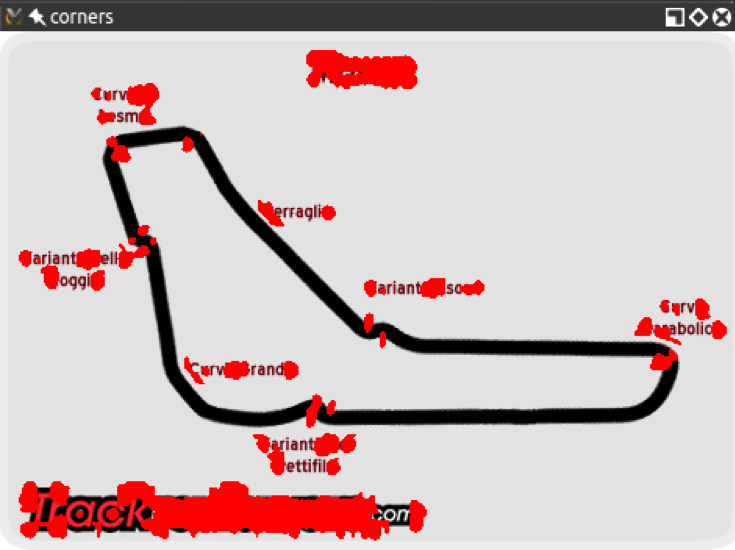

Aquí está el resultado de la detección de esquinas con una versión más pequeña de la misma imagen:

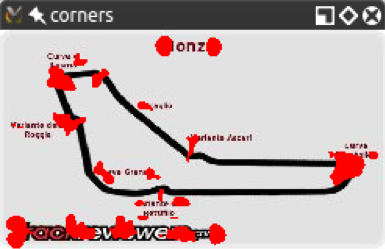

Notarás cómo las curvas están mucho más condensadas; sin embargo, aunque hemos ganado algunas curvas, ¡hemos perdido otras! En concreto, examinemos la chicane Variante Ascari, que parece un garabato al final de la parte de la pista que discurre recta de noroeste a sureste. En la versión ampliada de la imagen, tanto la entrada como el vértice de la doble curva se detectaron como curvas. En la imagen más pequeña, el vértice no se detecta como tal. Si reducimos aún más la imagen, a cierta escala, perderemos también la entrada a esa chicane.

Esta pérdida de características plantea un problema: necesitamos un algoritmo que funcione independientemente de la escala de la imagen. Aquí entra en juego la **transformada de características invariantes de escala (SIFT)**. Aunque el nombre puede sonar un poco misterioso, ahora que sabemos qué problema estamos tratando de resolver, en realidad tiene sentido. Necesitamos una función (una transformada) que detecte características (una transformada de características) y que no produzca resultados diferentes dependiendo de la escala de la imagen (una transformada de características invariante de escala). Tenga en cuenta que SIFT no detecta puntos clave. La detección de puntos clave se realiza con la Diferencia de Gaussianos (DoG), mientras que SIFT describe la región que rodea los puntos clave mediante un vector de características.

Conviene hacer una rápida introducción a la DoG. Anteriormente, en el Capítulo 3, Procesamiento de imágenes con OpenCV, hablamos de los filtros de paso bajo y las operaciones de desenfoque, y específicamente de la función cv2.GaussianBlur. DoG es el resultado de aplicar diferentes filtros gaussianos a la misma imagen. Anteriormente, aplicamos este tipo de técnica para la detección de bordes, y la idea es la misma aquí. El resultado final de una operación DoG contiene áreas de interés (keypoints), que luego van a ser descritas a través de SIFT.

Veamos cómo se comportan DoG y SIFT en la siguiente imagen, que está llena de esquinas y características:

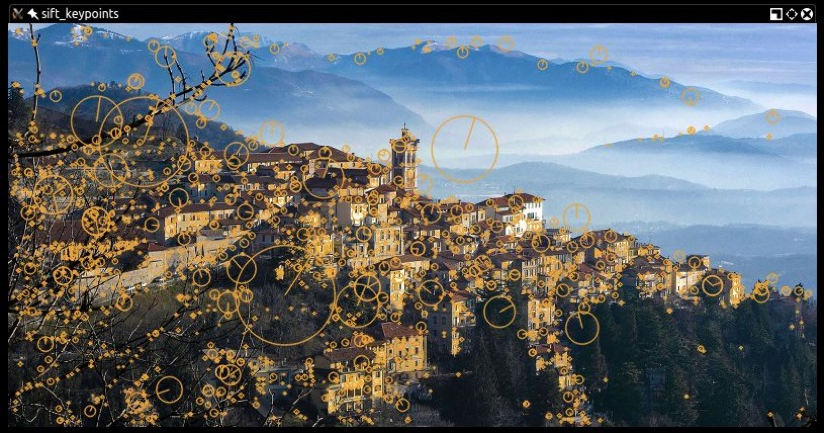

Aquí, el hermoso panorama de Varese (en Lombardía, Italia) gana un nuevo tipo de fama como tema de visión por ordenador. He aquí el código que produce esta imagen procesada:


```python
import cv2
img = cv2.imread('../images/varese.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
cv2.drawKeypoints(img, keypoints, img, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('sift_keypoints', img)
cv2.waitKey()
```

Tras las importaciones habituales, cargamos la imagen que queremos procesar. A continuación, convertimos la imagen en escala de grises. A estas alturas, te habrás dado cuenta de que muchos métodos en OpenCV esperan una imagen en escala de grises como entrada. El siguiente paso es crear un objeto de detección SIFT y calcular las características y descriptores de la imagen en escala de grises:

```python
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
```

Entre bastidores, estas sencillas líneas de código llevan a cabo un elaborado proceso; creamos un objeto cv2.SIFT, que utiliza DoG para detectar puntos clave y, a continuación, calcula un vector de características para la región circundante de cada punto clave. Como sugiere claramente el nombre del método detectAndCompute, se realizan dos operaciones principales: la detección de características y el cálculo de descriptores. El valor de retorno de la operación es una tupla que contiene una lista de puntos clave y otra lista de descriptores de los puntos clave.

Por último, procesamos esta imagen dibujando los puntos clave sobre ella con la función cv2.drawKeypoints y mostrándola después con la función habitual cv2.imshow. Como uno de sus argumentos, la función cv2.drawKeypoints acepta una bandera que especifica el tipo de visualización que queremos. Aquí, especificamos cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINT para dibujar una visualización de la escala y orientación de cada keypoint.

### Anatomía de un punto clave
Cada punto clave es una instancia de la clase cv2.KeyPoint, que tiene las siguientes propiedades:

---

* La propiedad pt (punto) contiene las coordenadas x e y del punto clave en la imagen.
* La propiedad tamaño indica el diámetro de la característica.
* La propiedad angle indica la orientación de la característica, tal y como muestran las líneas radiales en la imagen procesada anterior.
* La propiedad de respuesta indica la fuerza del punto clave. Algunas características son clasificadas por SIFT como más fuertes que otras, y la respuesta es la propiedad que usted comprobaría para evaluar la fuerza de una característica.
* La propiedad octava indica la capa en la pirámide de la imagen donde se encontró la característica. Repasemos brevemente el concepto de pirámide de imágenes, del que ya hablamos en el Capítulo 5, Detección y reconocimiento de caras, en la sección Conceptualización de las cascadas de Haar. El algoritmo SIFT funciona de forma similar a los algoritmos de detección de caras, ya que procesa la misma imagen de forma iterativa pero altera la entrada en cada iteración. En concreto, la escala de la imagen es un parámetro que cambia en cada iteración (octava) del algoritmo. Así, la propiedad octave está relacionada con la escala de la imagen en la que se detectó el punto clave.
* Por último, la propiedad class_id puede utilizarse para asignar un identificador personalizado a un punto clave o a un grupo de puntos clave.

---

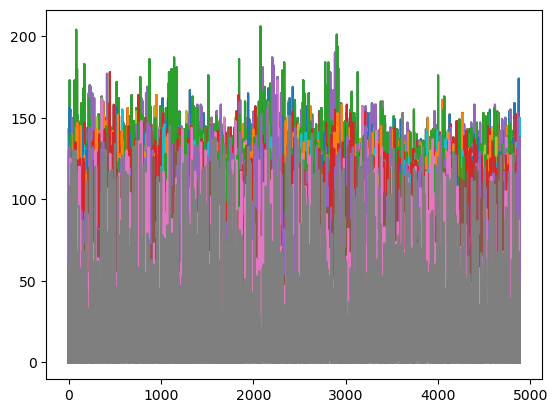

[[ 33.  37.  64. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   2.]
 [  2.   1.   0. ...   0.   0.   0.]
 ...
 [ 41. 102.  35. ...   0.   0.   0.]
 [  5.   6.   6. ...   2.   1.  12.]
 [  1.   1.   0. ...   6.   9.   3.]]


In [4]:
import cv2 
imagen = cv2.imread("sources/varese.jfif")
imagen = cv2.resize(imagen, (800, 600))
import matplotlib.pyplot as plt
import matplotlib.image as img

gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
puntosClave, descriptores = sift.detectAndCompute(gris, None)

plt.plot(descriptores)
plt.show()

cv2.drawKeypoints(imagen, puntosClave, imagen, (51, 163, 236), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(descriptores)

cv2.imshow('IMAGEN1', imagen)
cv2.waitKey()
cv2.destroyAllWindows()

## Detección de características hessianas rápidas y extracción de descriptores SURF
La visión por ordenador es una rama relativamente joven de la informática, por lo que muchos algoritmos y técnicas famosos se han inventado recientemente. De hecho, SIFT sólo tiene 23 años y fue publicado por David Lowe en 1999.

SURF es un algoritmo de detección de características publicado en 2006 por Herbert Bay. SURF es varias veces más rápido que SIFT, y está parcialmente inspirado en él.

Tenga en cuenta que SURF es un algoritmo patentado y, por esta razón, sólo está disponible en versiones de opencv_contrib donde se utiliza la bandera CMake OPENCV_ENABLE_NONFREE. SIFT fue anteriormente un algoritmo patentado pero su patente expiró y ahora SIFT está disponible en compilaciones estándar de OpenCV.

No es particularmente relevante para este libro entender cómo funciona SURF bajo el capó, en la medida en que podemos utilizarlo en nuestras aplicaciones y sacar lo mejor de él. Lo que es importante entender es que cv2.SURF es una clase de OpenCV que realiza la detección de puntos clave con el algoritmo Fast Hessian y la extracción de descriptores con SURF, al igual que la clase cv2.SIFT realiza la detección de puntos clave con DoG y la extracción de descriptores con SIFT.

Además, la buena noticia es que OpenCV proporciona una API estandarizada para todos sus algoritmos soportados de detección de características y extracción de descriptores. Por lo tanto, con sólo cambios triviales, podemos adaptar nuestro ejemplo de código anterior para utilizar SURF en lugar de SIFT. Aquí está el código modificado, con los cambios resaltados:

```python
import cv2
img = cv2.imread('../images/varese.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
surf = cv2.xfeatures2d.SURF_create(8000)
keypoints, descriptor = surf.detectAndCompute(gray, None)
cv2.drawKeypoints(img, keypoints, img, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('surf_keypoints', img)
cv2.waitKey()
```

El parámetro de cv2.xfeatures2d.SURF_create es un umbral para el algoritmo Fast Hessian. Aumentando el umbral, podemos reducir el número de características que serán retenidas. Con un umbral de 8000, obtenemos el siguiente resultado:

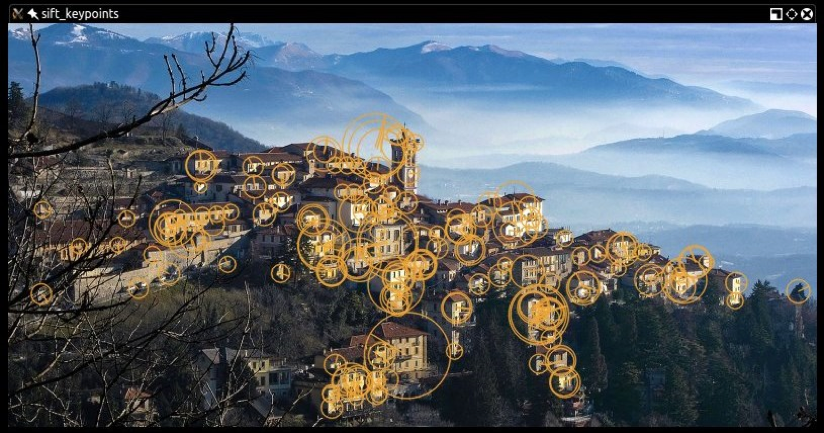

Prueba a ajustar el umbral para ver cómo afecta al resultado. Como ejercicio, puede crear una aplicación GUI con un control deslizante que controle el valor del umbral. De esta manera, un usuario puede ajustar el umbral y ver el número de características aumentar y disminuir de manera inversamente proporcional. Construimos una aplicación GUI con controles deslizantes en el Capítulo 4, Estimación de profundidad y segmentación, en la sección Estimación de profundidad con una cámara normal, por lo que puede que desee volver a esa sección como guía.

A continuación, examinaremos el detector de esquinas FAST, el descriptor de puntos clave BRIEF y ORB (que utiliza FAST y BRIEF juntos).



## Uso de ORB con características FAST y descriptores BRIEF
Si SIFT es joven, y SURF más joven, ORB está en su infancia. ORB se publicó por primera vez en 2011 como una alternativa rápida a SIFT y SURF.

El algoritmo se publicó en el documento ORB: an efficient alternative to SIFT or SURF, disponible en formato PDF en http://www.willowgarage.com/sites/default/files/orb_final.pdf.

ORB mezcla las técnicas utilizadas en el detector de puntos clave FAST y en el descriptor de puntos clave BRIEF, por lo que merece la pena echar un vistazo rápido primero a FAST y BRIEF. A continuación, hablaremos de la concordancia por fuerza bruta -un algoritmo utilizado para la concordancia de características- y veremos un ejemplo de concordancia de características.

### FAST
El algoritmo FAST (Features from Accelerated Segment Test) funciona analizando vecindarios circulares de 16 píxeles. Marca cada píxel de un vecindario como más brillante u oscuro que un umbral determinado, que se define en relación con el centro del círculo. Se considera que un barrio es una esquina si contiene un número de píxeles contiguos marcados como más brillantes o más oscuros.

FAST también utiliza una prueba de alta velocidad, que a veces puede determinar que un vecindario no es una esquina comprobando sólo 2 ó 4 píxeles en lugar de 16. Para entender cómo funciona esta prueba, echemos un vistazo al siguiente diagrama, tomado de la documentación de OpenCV:

![image.png](attachment:image.png)


Aquí podemos ver un vecindario de 16 píxeles con dos aumentos diferentes. Los píxeles de las posiciones 1, 5, 9 y 13 corresponden a los cuatro puntos cardinales del borde de la zona circular. Si la vecindad es una esquina, esperamos que de estos cuatro píxeles, exactamente tres o exactamente uno sean más brillantes que el umbral. (Otra forma de decir esto es que exactamente uno o exactamente tres de ellos serán más oscuros que el umbral). Si exactamente dos de ellos son más brillantes que el umbral, entonces tenemos un borde, no una esquina. Si exactamente cuatro o exactamente cero de ellos son más brillantes que el umbral, entonces tenemos un vecindario relativamente uniforme que no es ni una esquina ni un borde.

FAST es un algoritmo inteligente, pero no está exento de debilidades, y para compensarlas, los desarrolladores que analizan imágenes pueden aplicar un enfoque de aprendizaje automático para alimentar un conjunto de imágenes (relevantes para una aplicación determinada) al algoritmo, de modo que se optimicen parámetros como el umbral. Tanto si el desarrollador especifica los parámetros directamente como si proporciona un conjunto de entrenamiento para un enfoque de aprendizaje automático, FAST es un algoritmo sensible a la entrada del desarrollador, quizás más que SIFT.

### BRIEF
**Binary Robust Independent Elementary Features (BRIEF)**, por su parte, no es un algoritmo de detección de características, sino un descriptor. Profundicemos en el concepto de lo que es un descriptor y, a continuación, analicemos **BRIEF**.

Cuando anteriormente analizábamos imágenes con SIFT y SURF, el corazón de todo el proceso era la llamada a la función detectAndCompute. Esta función realiza dos pasos diferentes -detección y computación- y devuelven dos resultados diferentes, acoplados en una tupla.

El resultado de la detección es un conjunto de puntos clave; el resultado del cálculo es un conjunto de descriptores para esos puntos clave. Esto significa que las clases cv2.SIFT y cv2.xfeatures2d.SURF de OpenCV implementan algoritmos tanto para la detección como para la descripción. Recuerde, sin embargo, que el original SIFT y SURF no son algoritmos de detección de características. OpenCV's cv2.SIFT implementa la detección de características DoG más la descripción SIFT, mientras que OpenCV's cv2.xfeatures2d.SURF implementa la detección de características Fast Hessian más la descripción SURF.

Los descriptores de puntos clave son una representación de la imagen que sirve como puerta de entrada a la correspondencia de características, ya que se pueden comparar los descriptores de puntos clave de dos imágenes y encontrar puntos en común.

BRIEF es uno de los descriptores más rápidos que existen en la actualidad. La teoría que hay detrás de BRIEF es bastante complicada, pero baste decir que BRIEF adopta una serie de optimizaciones que lo convierten en una muy buena opción para la concordancia de características.

### Comparación de fuerza bruta
Un emparejador de fuerza bruta es un emparejador de descriptores que compara dos conjuntos de descriptores de puntos clave y genera un resultado que es una lista de coincidencias. Se denomina de fuerza bruta porque el algoritmo apenas requiere optimización. Para cada descriptor de punto clave del primer conjunto, el emparejador realiza comparaciones con cada descriptor de punto clave del segundo conjunto. Cada comparación produce un valor de distancia y la mejor coincidencia puede elegirse en función de la menor distancia.

De forma más general, en informática, el término fuerza bruta se asocia a un enfoque que da prioridad al agotamiento de todas las combinaciones posibles (por ejemplo, todas las combinaciones posibles de caracteres para descifrar una contraseña de longitud conocida). Por el contrario, un algoritmo que prioriza la velocidad puede saltarse algunas posibilidades e intentar tomar un atajo hacia la solución que parezca más plausible.

OpenCV proporciona una clase `cv2.BFMatcher` que soporta varias aproximaciones a la comparación de características por fuerza bruta.

### Comparación de un logotipo en dos imágenes
Ahora que tenemos una idea general de lo que son FAST y BRIEF, podemos entender por qué el equipo detrás de ORB (compuesto por Ethan Rublee, Vincent Rabaud, Kurt Konolige y Gary R. Bradski) eligió estos dos algoritmos como base para ORB.

En su artículo, los autores se proponen alcanzar los siguientes resultados:

---

* Añadir a FAST un componente de orientación rápido y preciso.
* El cálculo eficaz de las características orientadas de BRIEF
* Análisis de varianza y correlación de las características BRIEF orientadas
* Un método de aprendizaje para descorrelacionar las características BRIEF bajo invarianza rotacional, lo que conduce a un mejor rendimiento en aplicaciones de vecino más cercano.

---

Los puntos principales son bastante claros: ORB pretende optimizar y acelerar las operaciones, incluido el paso muy importante de utilizar BRIEF de una manera que tenga en cuenta la rotación, de modo que se mejore la correspondencia, incluso en situaciones en las que una imagen de entrenamiento tenga una rotación muy diferente a la de la imagen de consulta.


A estas alturas, sin embargo, quizás ya se haya cansado de la teoría y quiera hincarle el diente a la comparación de características, así que veamos algo de código. El siguiente script intenta hacer coincidir las características de un logotipo con las características de una fotografía que contiene el logotipo:

```python
import cv2
from matplotlib import pyplot as plt
# Load the images.
img0 = cv2.imread('../images/nasa_logo.png',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('../images/kennedy_space_center.jpg',
                  cv2.IMREAD_GRAYSCALE)
# Perform ORB feature detection and description.
orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)
# Perform brute-force matching.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)
# Sort the matches by distance.
matches = sorted(matches, key=lambda x:x.distance)
# Draw the best 25 matches.
img_matches = cv2.drawMatches(
    img0, kp0, img1, kp1, matches[:25], img1,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# Show the matches.
plt.imshow(img_matches)
plt.show()

```

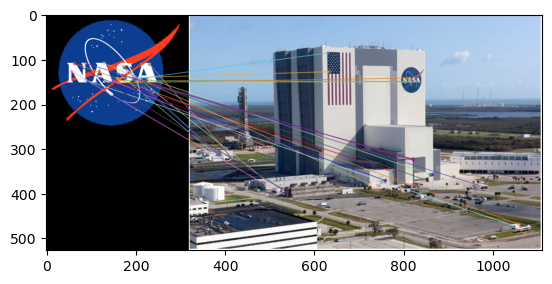

In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as img

imagen1 = cv2.imread("sources/nasa.png")
imagen2 = cv2.imread("sources/centro kennedy.png")

#Caracterizar
orb = cv2.ORB_create()
k_p0, desc_0 = orb.detectAndCompute(imagen1, None)
k_p1, desc_1 = orb.detectAndCompute(imagen2, None)

#Caracteristica de fuerza bruta
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(desc_0, desc_1)


matches = sorted(matches, key=lambda x:x.distance)

#Dibujar los mejores puntos match
img_matches = cv2.drawMatches(
    imagen1, k_p0, imagen2, k_p1, matches[:25], imagen1, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
)


#Ver los puntos
img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

plt.imshow(img_matches)
plt.show()

